# Spectral indices

In [1]:
import glob, os
import numpy as np
import pandas as pd
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
from pathlib import Path

print('All libraries successfully imported!')

All libraries successfully imported!


**Set the index name you want to compute !**

- NDVI
- NDWI
- NDSI
- BRIGHTNESS
- NBR
- BAIS2
- SWI

In [2]:
index_name = 'NDVI'

nodata_val = -10000

print(f'You chose to compute {index_name} !')

You chose to compute NDVI !


## Set directory

In [3]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_letter    = 'X'

# Directory for all work files
work_path = f'{computer_path}GROUP_{grp_letter}/WORK/'

reflectance_path = f'{work_path}3_L2A_MASKED/'

index_path = f'{work_path}{index_name}/'

Path(index_path).mkdir(parents=True, exist_ok=True)

> **What do you need to compute the selected spectral indices ?**

In [4]:
if index_name == 'NDVI':
    bands_needed = ['B04','B08']
    list_im_path = [reflectance_path,
                    reflectance_path]

elif index_name == 'NDWI':
    bands_needed = ['B08','B11']
    list_im_path = [reflectance_path,
                    reflectance_path]

elif index_name == 'NDSI':
    bands_needed = ['B03','B11']
    list_im_path = [reflectance_path,
                    reflectance_path]

elif index_name == 'BRIGHTNESS':
    bands_needed = ['B03','B04','B08','B11']
    list_im_path = [reflectance_path,
                    reflectance_path,
                    reflectance_path,
                    reflectance_path]

elif index_name == 'NBR':
    bands_needed = ['B08','B12']
    list_im_path = [reflectance_path,
                    reflectance_path]

elif index_name == 'BAIS2':
    bands_needed = ['B04','B06','B07','B8A','B12']
    list_im_path = [reflectance_path,
                    reflectance_path,
                    reflectance_path,
                    reflectance_path]

elif index_name == 'SWI':
    bands_needed = ['NDVI','NDWI']
    list_im_path = [f'{work_path}NDVI/',
                    f'{work_path}NDWI/']


print(f'To compute {index_name} you need : {bands_needed}')

To compute NDVI you need : ['B04', 'B08']


**Check if you have the necessary spectral bands**

In [5]:
for i,band in enumerate(bands_needed):
    
    print(f'We need band/index {band} to compute {index_name}')
    list_im = glob.glob(f'{list_im_path[i]}*{band}*.tif')
    
    nb_im = len(list_im)
    print(f'--> {nb_im} images are found \n')

print('Check if the number of images found for each band/index is the same !!')


We need band/index B04 to compute NDVI
--> 12 images are found 

We need band/index B08 to compute NDVI
--> 12 images are found 

Check if the number of images found for each band/index is the same !!


## Compute spectral index selected for all images

In [9]:
for i in range(0,nb_im):
    
    im = sorted(glob.glob(f'{list_im_path[0]}*{bands_needed[0]}*.tif'))[i]
    date = os.path.basename(im)[7:15]
    print(f'Date : {date}')

    list_im = [im]

    for n,band in enumerate(bands_needed[1:]):
        im = glob.glob(f'{list_im_path[n+1]}*{date}*{band}*.tif')[0]
        list_im.append(im)

    # Name the output SI file
    index_file = f'{index_path}{os.path.basename(list_im[0])[0:22]}_{index_name}.tif'
    
    if not os.path.isfile(index_file):
        
        # Create a list with all reflectance images needed to compute the SI in Numpy array
        list_im_arr = []

        for im_file in list_im:

            # Open band and update metadata
            src = rasterio.open(im_file, 'r')
            profile = src.profile
            profile.update(dtype=rasterio.float64)
            im = src.read(1)

            # Convert no-data value into Numpy NaN
            im = im.astype(np.float)
            im[im == nodata_val] = np.nan
            
            src.close()

            list_im_arr.append(im)
        
        # Compute Spectral Index
        
        if index_name == 'NDVI':
            red = list_im_arr[0] # B04
            nir = list_im_arr[1] # B08

            index_arr = (nir - red) / (nir + red)

        elif index_name == 'NDWI':
            nir  = list_im_arr[0] # B08
            swir = list_im_arr[1] # B11

            index_arr = (nir - swir) / (nir + swir)
        
        elif index_name == 'NDSI':
            green = list_im_arr[0] # B03
            swir  = list_im_arr[1] # B11 
            
            index_arr = (green - swir) / (green + swir)
        
        elif index_name == 'NBR':
            nir  = list_im_arr[0] # B08
            swir = list_im_arr[1] # B12

            index_arr = (nir - swir) / (nir + swir)
        
        elif index_name == 'BRIGHTNESS':
            green = list_im_arr[0] # B03
            red   = list_im_arr[1] # B04
            nir   = list_im_arr[2] # B08
            swir  = list_im_arr[3] # B11

            index_arr = np.sqrt(np.square(green) + np.square(red) + np.square(nir) + np.square(swir))

        elif index_name == 'BAIS2':
            red         = list_im_arr[0] # B04
            redEdge_B6  = list_im_arr[1] # B06
            redEdge_B7  = list_im_arr[2] # B07
            nir         = list_im_arr[3] # B08
            swir        = list_im_arr[4] # B12
            
            index_arr = (1-np.sqrt((redEdge_B6*redEdge_B7*nir)/red))*((swir-nir)/(np.sqrt(swir+nir))+1)
        
        elif index_name == 'SWI':
            ndvi = list_im_arr[0] # NDVI
            ndwi = list_im_arr[1] # NDWI

            index_arr = np.square(ndvi - ndwi)
        
        # Write Spectral Index image into GeoTIFF

        dst = rasterio.open(index_file, "w", **profile)
        dst.write(index_arr,1)
        dst.close()

        print(f'A new {index_name} file is created : {index_file}')
    

print(f'--> All {index_name} are computed !')


Date : 20200116
Date : 20200212
Date : 20200316
Date : 20200417
Date : 20200520
Date : 20200621
Date : 20200719
Date : 20200813
Date : 20200914
Date : 20201019
Date : 20201118
Date : 20201218
--> All NDVI are computed !


## Plot a spectral index

### Open spectral index file with rasterio

In [17]:
im_file = index_file
print(im_file)
src = rasterio.open(im_file, "r")

/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20201218T104349_NDVI.tif


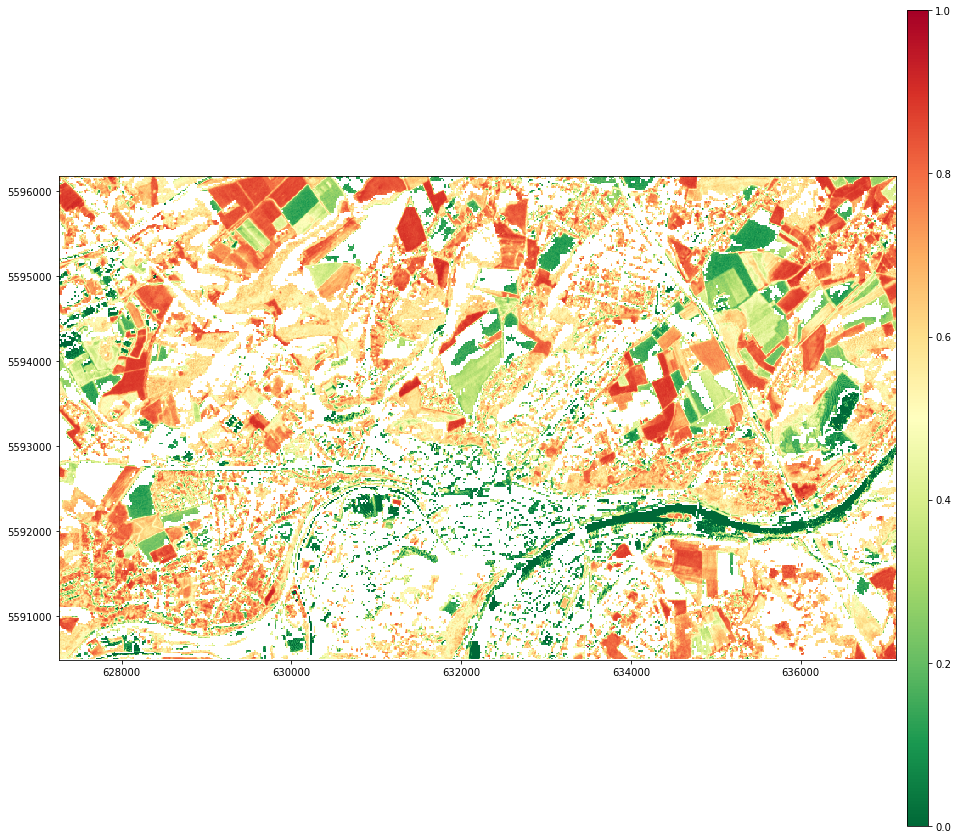

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

color_map = plt.cm.get_cmap("RdYlGn")
reversed_color_map = color_map.reversed()


im_rio = rasterio.plot.show(src, cmap=reversed_color_map, vmin=0, vmax=1, ax=ax)
im_rio = im_rio.get_images()[0]

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)

plt.box(False)